In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.nn.functional as F

from torchvision import transforms
from torchvision.datasets import ImageFolder
from mechanism import Attack
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
download_url('https://download.pytorch.org/models/convnext_base-6075fbad.pth', '.')
pretrained_model_convnext_base = 'convnext_base-6075fbad.pth'

Using downloaded and verified file: .\convnext_base-6075fbad.pth


In [4]:
model = torchvision.models.convnext_base(weights='DEFAULT')
model = model.to(device)

In [5]:
model.load_state_dict(torch.load(pretrained_model_convnext_base, map_location=device))
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [6]:
labels_file = 'imagenet1000_clsidx_to_labels.txt'

with open(labels_file, "r") as file:
    contents = file.readlines()

labels = {}

for line in contents:
    line = line.strip()
    key, value = line.split(":")
    key = int(key)
    value = value.strip(" '")
    value = value.strip("',")
    value = value.split(", ")
    labels[key] = value
    
small_dataset = {0:0, 217:1, 482:2, 491:3, 497:4, 566:5, 569:6, 571:7, 574:8, 701:9}
label = {0:labels[0], 1:labels[217], 2:labels[482], 3:labels[491], 4:labels[497], 
         5:labels[566], 6:labels[569], 7:labels[571], 8:labels[574], 9:labels[701]}
print(small_dataset)

{0: 0, 217: 1, 482: 2, 491: 3, 497: 4, 566: 5, 569: 6, 571: 7, 574: 8, 701: 9}


In [7]:
def count_files(path):
    count = []
    for _, _, files in os.walk(path):
        if files == []:
            continue
        else:
            count.append(len(files))
    return count
    
train_count = count_files('data/imagenette2-320/train')
test_count = count_files('data/imagenette2-320/val')
print(train_count)

[963, 955, 993, 858, 941, 956, 961, 931, 951, 960]


In [8]:
train_transform = transforms.Compose([
                          transforms.ToTensor()])
                         
test_transform = transforms.Compose([
                         transforms.ToTensor()])

ds_train = ImageFolder('data/imagenette2-320/train', train_transform)
ds_test  = ImageFolder('data/imagenette2-320/val', test_transform)

In [15]:
def add_target(count, ds):
    target = []
    for i in range(10):
        for j in range(count[i]):
            target.append(ds.classes[i])
    return target

ds_train.target = add_target(train_count, ds_train)
ds_test.target = add_target(test_count, ds_test)

dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1)

In [16]:
def test(model, device, test_loader, epsilon, attack_type):
    correct = 0
    adv_examples = []
    attack = Attack(epsilon)
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        #print(output)
        
        if init_pred.item() not in small_dataset.keys():
            continue
        elif small_dataset[init_pred.item()]!= target.item():
            continue
        
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        
        if attack_type == 'fgsm':
            perturbed_image = attack.fgsm(data, data_grad)
        elif attack_type == 'ifgsm':
            perturbed_image = attack.ifgsm(data, data_grad)
            
        output = model(perturbed_image)
        final_pred = output.max(1, keepdim=True)[1]
        #print(output)
        
        if final_pred.item() in small_dataset.keys():
            if small_dataset[final_pred.item()] == target.item():
                correct += 1
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                    adv_examples.append( (small_dataset[init_pred.item()], small_dataset[final_pred.item()], adv_ex) )
            else:
                if len(adv_examples) < 5:
                    adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                    adv_examples.append( (small_dataset[init_pred.item()], small_dataset[final_pred.item()], adv_ex) )        

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {}/{} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples
    #print(model(perturbed_image))

In [17]:
def plot_graph(accuracies):
    plt.figure(figsize=(7,7))
    plt.plot(epsilons, accuracies, "*-")
    plt.yticks(np.arange(0, 1.0, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

In [18]:
def visualize_adversarial(examples):
    cnt = 0
    plt.figure(figsize=(15,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons), len(examples[0]), cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(label[orig][0], label[adv][0]))
            plt.imshow(ex[0,:,:])

    plt.tight_layout()
    plt.show()

In [19]:
epsilons = [0, .05, .1]

In [21]:
accuracies_fgsm_attack = []
examples_fgsm_attack = []

for eps in epsilons:
    acc, ex = test(model, device, dataloader_test, eps, attack_type="fgsm")
    accuracies_fgsm_attack.append(acc)
    examples_fgsm_attack.append(ex)

print(eps)

Epsilon: 0	Test Accuracy = 3348/3925 = 0.8529936305732484
Epsilon: 0.05	Test Accuracy = 1317/3925 = 0.3355414012738854
Epsilon: 0.1	Test Accuracy = 951/3925 = 0.24229299363057324
0.1


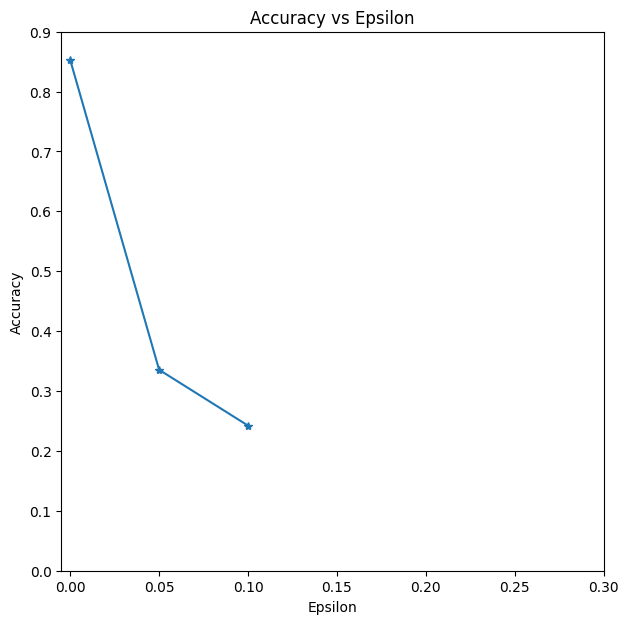

In [22]:
plot_graph(accuracies_fgsm_attack)

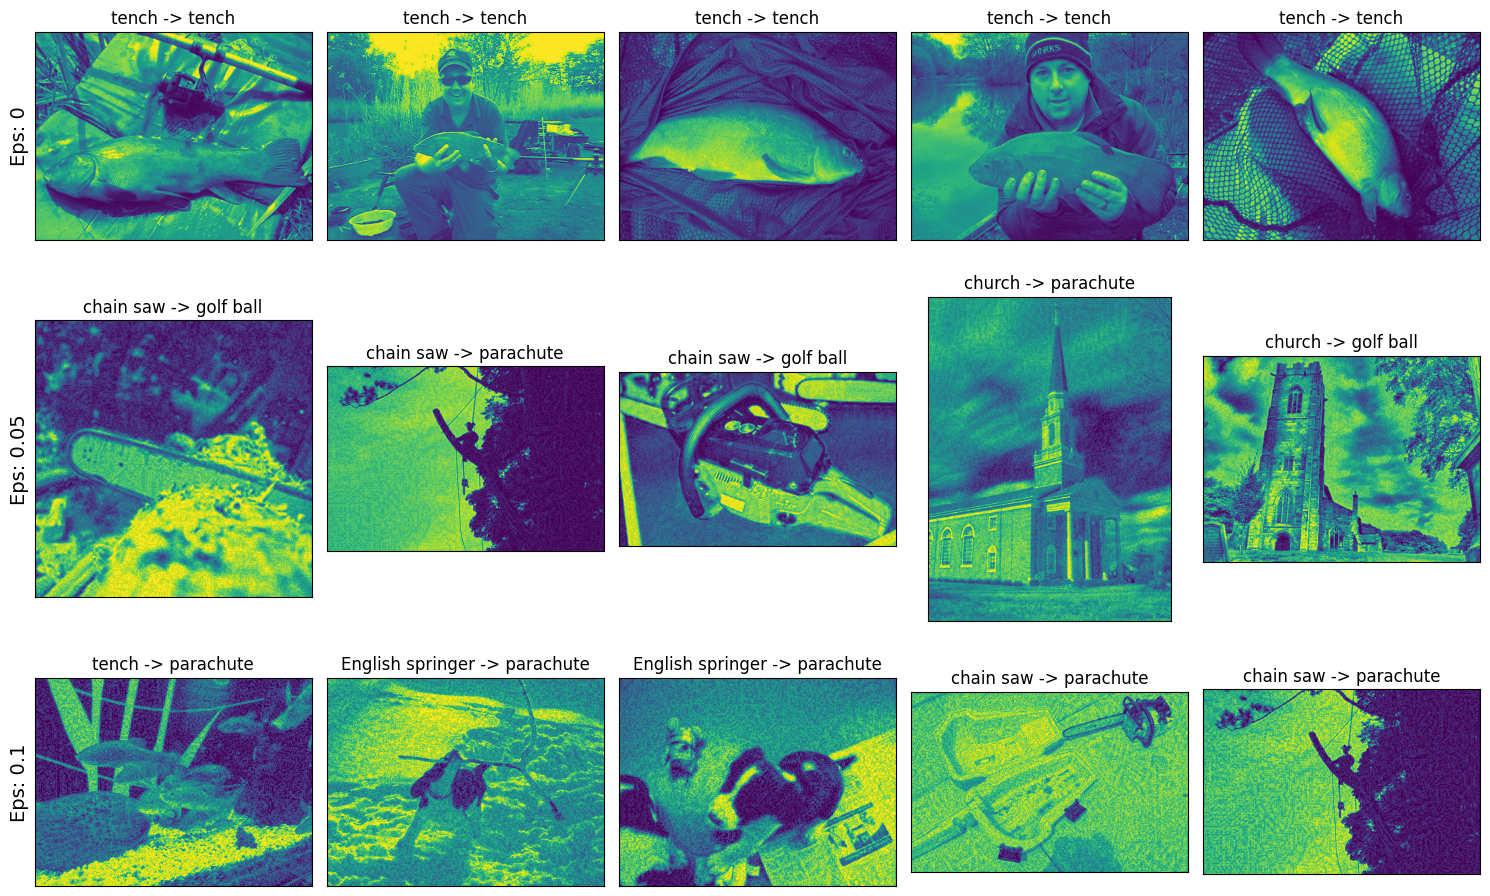

In [23]:
visualize_adversarial(examples_fgsm_attack)

In [25]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.Resize((256,256)),
                        transforms.CenterCrop((224,224)),
                        transforms.ToTensor(),
                        normalize])
                         
test_transform = transforms.Compose([transforms.Resize((256,256)),
                        transforms.CenterCrop((224,224)),
                        transforms.ToTensor(),
                        normalize])

ds_train = ImageFolder('data/imagenette2-320/train', train_transform)
ds_test  = ImageFolder('data/imagenette2-320/val', test_transform)

def add_target(count, ds):
    target = []
    for i in range(10):
        for j in range(count[i]):
            target.append(ds.classes[i])
    return target

ds_train.target = add_target(train_count, ds_train)
ds_test.target = add_target(test_count, ds_test)

dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1)

In [26]:
def plot_difference(attack_accuracy, defense_accuracy):
    fig = plt.figure(figsize=(7,7))
    plt.yticks(np.arange(0, 1.0, step=0.1))
    plt.xticks(np.arange(0, 0.35, step=0.05))
    plt.plot(epsilons, attack_accuracy, "*-", label="Attack")
    plt.plot(epsilons, defense_accuracy, "o-", label="Defense")
    plt.title("Attack vs Defense")
    plt.xlabel("Epsilons")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [27]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.Resize((256,256)),
                        transforms.CenterCrop((224,224)),
                        transforms.ToTensor(),
                        normalize])
                         
test_transform = transforms.Compose([transforms.Resize((256,256)),
                        transforms.CenterCrop((224,224)),
                        transforms.ToTensor(),
                        normalize])

ds_train = ImageFolder('data/imagenette2-320/train', train_transform)
ds_test  = ImageFolder('data/imagenette2-320/val', test_transform)

def add_target(count, ds):
    target = []
    for i in range(10):
        for j in range(count[i]):
            target.append(ds.classes[i])
    return target

ds_train.target = add_target(train_count, ds_train)
ds_test.target = add_target(test_count, ds_test)

dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1)

In [36]:
def plot_difference(attack_accuracy, defense_accuracy):
    fig = plt.figure(figsize=(7,7))
    plt.yticks(np.arange(0, 1.0, step=0.1))
    plt.xticks(np.arange(0, 0.3, step=0.05))
    plt.plot(epsilons, attack_accuracy, "*-", label="Attack")
    plt.plot(epsilons, defense_accuracy, "o-", label="Defense")
    plt.title("Attack vs Defense")
    plt.xlabel("Epsilons")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [29]:
accuracies_fgsm_defense = []
examples_fgsm_defense = []

for eps in epsilons:
    acc, ex = test(model, device, dataloader_test, eps, attack_type="fgsm")
    accuracies_fgsm_defense.append(acc)
    examples_fgsm_defense.append(ex)

Epsilon: 0	Test Accuracy = 2923/3925 = 0.7447133757961784
Epsilon: 0.05	Test Accuracy = 2735/3925 = 0.6968152866242038
Epsilon: 0.1	Test Accuracy = 2575/3925 = 0.6560509554140127


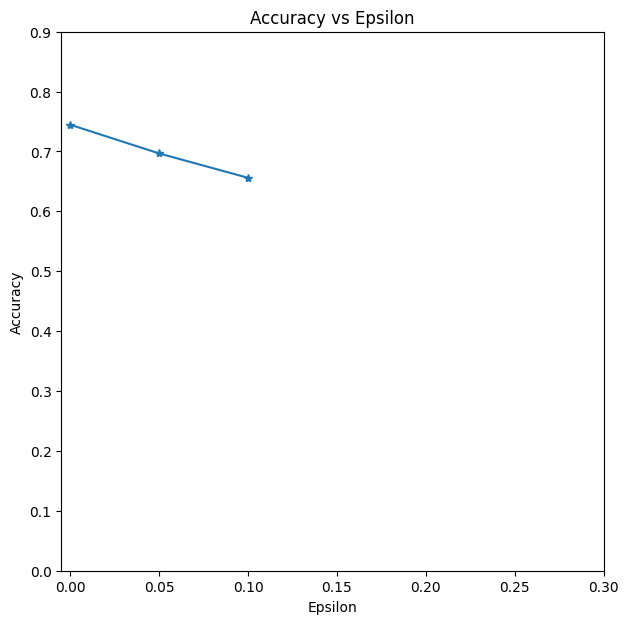

In [34]:
plot_graph(accuracies_fgsm_defense)

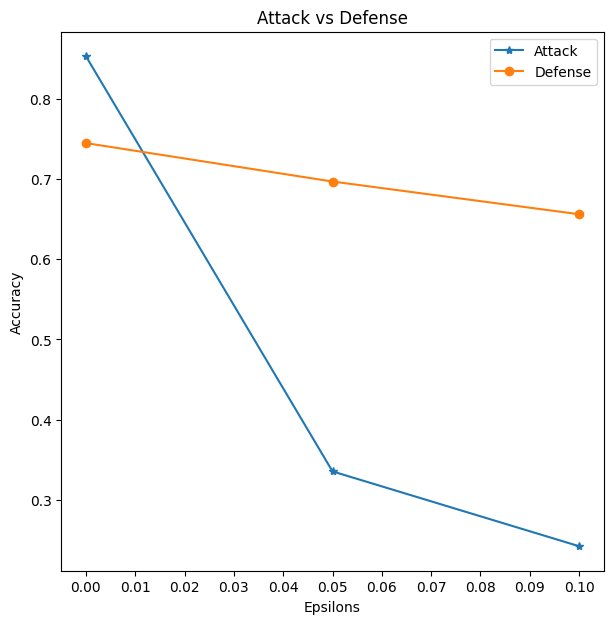

In [35]:
plot_difference(accuracies_fgsm_attack, accuracies_fgsm_defense)